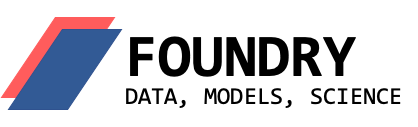

# Foundry Bandgap Data Quickstart for Beginners
This introduction uses Foundry to:


1.   Instantiate and authenticate a Foundry client locally or in the cloud
2.   Aggregate data from the collected datasets
3. Build a simple predictive model



This notebook is set up to run as a [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) notebook, which allows you to run python code in the browser, or as a [Jupyter](https://jupyter.org/) notebook, which runs locally on your machine.

The code in the next cell will detect your environment to make sure that only cells that match your environment will run.


In [1]:
try:
  import google.colab
  no_local_server = True
  no_browser = True
  globus = False
except: # when not in google colab
  no_local_server = False
  no_browser = False
  globus = True

# Environment Set Up
First we need to install and import all the packages we'll be using in this tutorial. Make sure you have [MDF](https://materialsdatafacility.org/) and Foundry installed in your local environment if running on your machine. We'll be using [Matminer](https://github.com/hackingmaterials/matminer) to featurize our data, so we'll need to install that too. If you're running this notebook in Google Colab, just run the cell below to install.


In [2]:
!pip install -r requirements.txt

We need to import a few packages. We'll be using [Matplotlib](https://matplotlib.org/) to make visualizations of our data, [scikit-learn](https://scikit-learn.org/stable/) to create our model, and [pandas](https://pandas.pydata.org/) and [NumPy ](https://numpy.org/)to work with our data.

In [3]:
%matplotlib inline

from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
import glob
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


warnings.filterwarnings('ignore')

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

# Instantiate and Authenticate Foundry
Once the installations are complete, we can import Foundry.

In [4]:
from foundry import Foundry

We'll also need to instantiate it. To do so, you'll need a [Globus](https://www.globus.org) account. Once you have your account, you can instantiate Foundry using the code below. When you instantiate Foundry locally, be sure to have your Globus endpoint turned on (you can do that with [Globus Connect Personal](https://www.globus.org/globus-connect-personal)). When you instantiate Foundry on Google Colab, you'll be given a link in the cell's output and asked to enter the provided auth code.

In [7]:
f = Foundry(no_local_server=no_local_server, no_browser=no_browser)

<bound method Foundry.list of Foundry(dc={}, mdf={}, dataset={}, config=FoundryConfig(dataframe_file='foundry_dataframe.json', data_file='foundry.hdf5', metadata_file='foundry_metadata.json', destination_endpoint=None, local=False, metadata_key='foundry', organization='foundry', local_cache_dir='./data'), dlhub_client=<dlhub_sdk.client.DLHubClient object at 0x7fe4eb9117f0>, forge_client=<mdf_forge.forge.Forge object at 0x7fe4db75f7f0>, connect_client=<mdf_connect_client.mdfcc.MDFConnectClient object at 0x7fe4eb911430>, xtract_tokens={'auth_token': 'AgwJBgv5q8yv8logGVxnBOQgyzkz40KYqkvNE2OOgBB2BYDKExilCNqVlX9G4Q0xQG41Qy2v2WDmPes27OE7DHoq2n', 'transfer_token': 'Agn2Dgngge62YYK6mzMzzKW8rMYMgD3k59n0g044p8KM6VlW5aH9CP8vle5vdJg7l1bWk9zkrNe93Vf0GwOG2TyNmq', 'funcx_token': 'Ag5N2BavMxMqDK0jldGnrWnjkpJr0xjnBvXn2Va7rlJ6pnKBeetnCw13xKJvwkBKN8zxljN3jGzMWYhKMaEMKU7J82'})>

# Loading the Band Gap Data
Now that we've installed and imported everything we'll need, it's time to load the data. We'll be loading 2 datasets from Foundry using `f.load` to load the data and then `f.load_data` to load the data into the client. Then we'll concatenate them using pandas.

In [10]:
f = f.load("test_double_perovskites_gap_v5.1", globus=globus)

X_mp,y_mp = f.load_data()

IndexError: list index out of range

In [ ]:
f = f.load("_test_foundry_mp_bandgap_v1.1", globus=globus)

X_assorted,y_assorted = f.load_data()

In [ ]:
X, y = pd.concat([X_oqmd, X_mp, X_assorted]), pd.concat([y_oqmd, y_mp, y_assorted])

Let's see the data!

In [ ]:
X.head()

,reference,icsd_id,structure,composition,comments,BG type,comp method,space group
0,OQMD,NaN,"{'@module': 'pymatgen.core.structure', '@class...",ScCoCuSb,OQMD PBE,,C-PBE,F-43m
1,OQMD,NaN,"{'@module': 'pymatgen.core.structure', '@class...",ScCoCuSb,OQMD PBE,,C-PBE,F-43m
2,OQMD,NaN,"{'@module': 'pymatgen.core.structure', '@class...",GaCoCuSb,OQMD PBE,,C-PBE,F-43m
3,OQMD,NaN,"{'@module': 'pymatgen.core.structure', '@class...",GaCoCuSb,OQMD PBE,,C-PBE,F-43m
4,OQMD,NaN,"{'@module': 'pymatgen.core.structure', '@class...",GaCoCuSb,OQMD PBE,,C-PBE,F-43m


# Add Composition Features
We need to pull out the composition data that will serve as our targets.

In [ ]:
n_datapoints = 100
data = StrToComposition(target_col_id='composition_obj')
data = data.featurize_dataframe(X[0:n_datapoints], 
                                 'composition', 
                                 ignore_errors=True)
y_subset = y[0:n_datapoints]['BG value (eV)']

StrToComposition:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
assert(len(y_subset) == len(data))

# Add Other Features
Choose the features that we'll use in training.

In [ ]:
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), 
                                          cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), 
                                          cf.IonProperty(fast=True)])
feature_labels = feature_calculators.feature_labels()

data = feature_calculators.featurize_dataframe(data, 
                                               col_id='composition_obj', 
                                               ignore_errors=False);

MultipleFeaturizer:   0%|          | 0/100 [00:00<?, ?it/s]

# Grid Search and Fit Model
Set up the grid search model using a random forest regressor as our estimator. Then, fit the model!

In [ ]:
quick_demo=True
est = RandomForestRegressor(n_estimators=30 if quick_demo else 150, n_jobs=-1)

model = GridSearchCV(est,
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',
                     cv=ShuffleSplit(n_splits=1,
                                     test_size=0.1))
model.fit(data[feature_labels], y_subset)


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.1, train_size=None),
             estimator=RandomForestRegressor(n_estimators=30, n_jobs=-1),
             param_grid={'max_features': range(8, 15)},
             scoring='neg_mean_squared_error')

# Cross Validation and Scoring
Perform cross validation to ensure our error values are below the desired thresholds.

In [ ]:
cv_prediction = cross_val_predict(model, 
                                  data[feature_labels],
                                   y_subset, 
                                  cv=KFold(10, shuffle=True))

In [ ]:
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(metrics,scorer)( y_subset, cv_prediction)
    print(scorer, score)

r2_score -0.06776246639223693
mean_absolute_error 0.01685663888888887
mean_squared_error 0.004569519799379617


# Make Plots
Plot the data for our bandgap analysis.

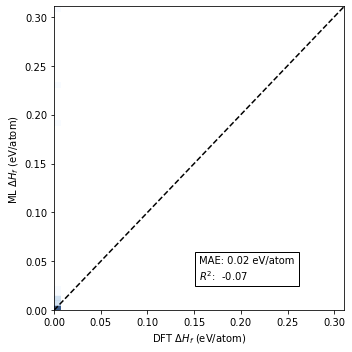

In [ ]:
fig, ax = plt.subplots()

ax.hist2d(pd.to_numeric( y_subset),
          cv_prediction, 
          norm=LogNorm(), 
          bins=64, 
          cmap='Blues', 
          alpha=0.8)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

mae = metrics.mean_absolute_error( y_subset, 
                                  cv_prediction)
r2 = metrics.r2_score( y_subset, 
                      cv_prediction)
ax.text(0.5, 0.1, 'MAE: {:.2f} eV/atom\n$R^2$:  {:.2f}'.format(mae, r2),
        transform=ax.transAxes,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax.set_ylabel('ML $\Delta H_f$ (eV/atom)')

fig.set_size_inches(5, 5)
fig.tight_layout()
fig.savefig('oqmd_cv.png', dpi=320)